In [7]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon

from src.vican.vican.cam import estimate_pose_mp
from src.vican.vican.bipgo import bipartite_se3sync, object_bipartite_se3sync
from src.vican.vican.plot import plot2D, plot_cams_3D, detect_and_draw
from src.vican.vican.dataset import Dataset

# Edit path to the folder containing the renders
DATASET_PATH = "./dataset/big_dataset"
# Edit path to the folder containing the cube calibration images.
OBJ_DATASET_PATH = "./dataset/big_dataset_object"
# Edit marker size in meters
MARKER_SIZE = 0.087                  # EDIT THIS LINE
# Check which IDs are used 
MARKER_IDS = ['10', '11', '12', '13', '2', '3', '4', '5', '6', '7', '8', '9']

dataset     = Dataset(root=DATASET_PATH)
obj_dataset = Dataset(root=OBJ_DATASET_PATH)

for k, v in dataset.cams.items():
    dataset.cams[k].distortion = np.zeros((1,12,))

for k, v in obj_dataset.cams.items():
    obj_dataset.cams[k].distortion = np.zeros((1,12,))

# Use below to rename object calib files (if needed) !!

In [34]:
import os
from PIL import Image
import os

# fix object image names

folders = os.listdir(OBJ_DATASET_PATH)
for folder in folders:
    if os.path.isdir(os.path.join(OBJ_DATASET_PATH, folder)):
        file = os.listdir(os.path.join(OBJ_DATASET_PATH, folder))[0].split('.')[0]
        if file != folder:
            os.rename(os.path.join(OBJ_DATASET_PATH, folder, file + ".png"), os.path.join(OBJ_DATASET_PATH, folder, folder + ".jpg"))
        print(folder, file)
        
# Define the function to convert PNG to JPG
for root, dirs, files in os.walk(DATASET_PATH):
    for file in files:
        if file.endswith(".png"):
            png_path = os.path.join(root, file)
            jpg_path = os.path.splitext(png_path)[0] + ".jpg"
            os.rename(png_path, jpg_path)



729 729
1559 1559
733 733
325 325
1141 1141
1041 1041
176 176
1838 1838
838 838
776 776
1565 1565
297 297
1188 1188
1131 1131
1124 1124
1050 1050
1827 1827
396 396
1672 1672
1388 1388
316 316
808 808
615 615
1215 1215
94 94
431 431
1738 1738
673 673
1103 1103
1728 1728
1242 1242
566 566
495 495
308 308
1315 1315
738 738
816 816
1147 1147
1383 1383
1429 1429
861 861
571 571
869 869
369 369
48 48
329 329
1612 1612
418 418
1277 1277
430 430
1192 1192
459 459
1442 1442
1812 1812
1717 1717
1327 1327
858 858
631 631
141 141
564 564
855 855
1489 1489
1629 1629
1907 1907
123 123
167 167
1650 1650
441 441
1132 1132
1117 1117
1290 1290
1920 1920
946 946
1600 1600
1941 1941
739 739
1919 1919
1878 1878
998 998
1563 1563
16 16
1370 1370
646 646
462 462
1922 1922
1443 1443
1258 1258
809 809
299 299
1554 1554
1138 1138
1473 1473
82 82
201 201
144 144
312 312
681 681
1884 1884
1588 1588
1924 1924
1699 1699
1211 1211
1239 1239
1821 1821
534 534
1222 1222
588 588
1627 1627
501 501
494 494
39 39
593 593


# Verify OpenCV detection

[5, 6, 7, 8, 9, 10]


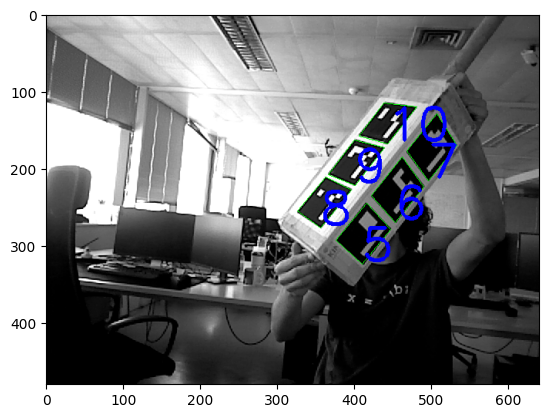

In [14]:
import cv2 as cv

im = detect_and_draw(obj_dataset.im_data['filename'][0], 'DICT_ARUCO_ORIGINAL', corner_refine='CORNER_REFINE_SUBPIX')
plt.imshow(im)

# Calibrate object

In [39]:
# This will compute camera-marker edges via PnP, in parallel
aux = estimate_pose_mp(cams=obj_dataset.im_data['cam'],
                       im_filenames=obj_dataset.im_data['filename'],
                       aruco='DICT_ARUCO_ORIGINAL',
                       marker_size=MARKER_SIZE,
                       corner_refine='CORNER_REFINE_SUBPIX',
                       marker_ids=MARKER_IDS,
                       flags='SOLVEPNP_IPPE_SQUARE',
                       brightness=-50,
                       contrast=100)

# Save it to use later, if necessary
torch.save(aux, os.path.join(OBJ_DATASET_PATH, 'cam_marker_edges.pt'))



Marker detection
Received 1998 images.
Started pool of 8 workers.
Merging dictionaries...
Found markers in 1995 images
Finished: 7823 markers detected.
Received graph with 2007 nodes 7823 edges
Applying constraints (0.153s).
Bipartite graph: 12 cameras, 1295 timesteps, 1886 edges.
Building 12x1295 adjacency and 36x3885 SO(3) sparse matrices (0.019s).
Building power graph (0.004s).


Optimizing:   0%|                    | 0/4 [00:00<?, ?it/s]

Building sparse 5658x3921 incidence matrix (0.316s).
Solving sparse linear system (0.024s).
Done!


In [44]:

# Optimization - see extended paper
obj_pose_est = object_bipartite_se3sync(aux,
                                        noise_model_r=lambda edge : 0.01 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**1,
                                        noise_model_t=lambda edge : 0.01 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**1,
                                        edge_filter=lambda edge : edge['reprojected_err'] < 0.4,
                                        maxiter=4,
                                        lsqr_solver="conjugate_gradient",
                                        dtype=np.float64)


Received graph with 2007 nodes 7823 edges
Applying constraints (0.189s).
Bipartite graph: 12 cameras, 1561 timesteps, 2702 edges.
Building 12x1561 adjacency and 36x4683 SO(3) sparse matrices (0.029s).
Building power graph (0.006s).


Optimizing:   0%|                    | 0/4 [00:00<?, ?it/s]

Building sparse 8106x4719 incidence matrix (0.443s).
Solving sparse linear system (0.023s).
Done!


# object edges errors

0.70647365
0.52779657


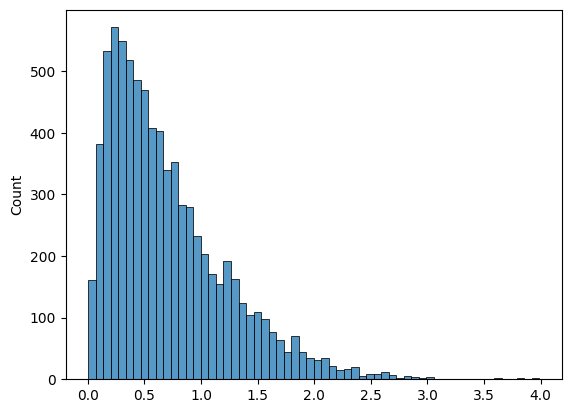

In [40]:
# plot histogram of reprojected errors
sns.histplot([edge['reprojected_err'] for edge in aux.values()])

# print the mean and std of the reprojected errors
print(np.mean([edge['reprojected_err'] for edge in aux.values()]))
print(np.std([edge['reprojected_err'] for edge in aux.values()]))

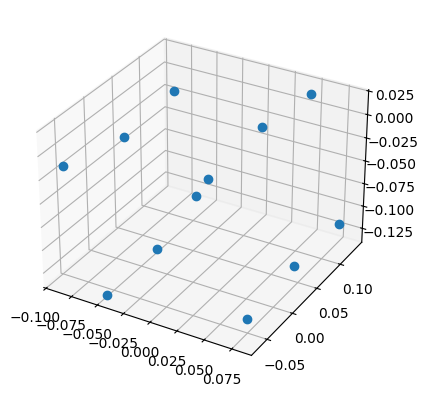

In [46]:
%matplotlib inline

xyz = np.stack([pose.inv().t() for pose in obj_pose_est.values()], axis=0)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(xyz[:,0], xyz[:,1], xyz[:,2], 'o')
plt.show()

# Detect markers & estimate camera-marker poses

In [17]:
# This will compute camera-marker edges via PnP, in parallel
cam_marker_edges = estimate_pose_mp(cams=dataset.im_data['cam'],
                                    im_filenames=dataset.im_data['filename'],
                                    aruco='DICT_ARUCO_ORIGINAL',
                                    marker_size=MARKER_SIZE,
                                    corner_refine='CORNER_REFINE_SUBPIX',
                                    marker_ids=MARKER_IDS,
                                    flags='SOLVEPNP_IPPE_SQUARE',
                                    brightness=-50,
                                    contrast=100)

# Save it to use later, if necessary
torch.save(cam_marker_edges, os.path.join(DATASET_PATH, 'cam_marker_edges.pt'))


Marker detection
Received 3747 images.
Started pool of 8 workers.
Merging dictionaries...
Found markers in 3491 images
Finished: 11735 markers detected.


# cam_marker errors

0.73733246 0.5670651


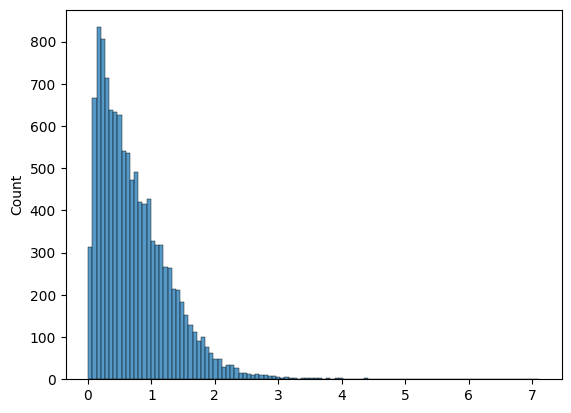

In [65]:
sns.histplot([edge['reprojected_err'] for edge in cam_marker_edges.values()])
# print the mean and std of the reprojected errors
print(np.mean([edge['reprojected_err'] for edge in cam_marker_edges.values()]),
      np.std([edge['reprojected_err'] for edge in cam_marker_edges.values()]))

# Optimization

In [47]:
# Optimization - see extended paper
pose_est = bipartite_se3sync(cam_marker_edges,
                             constraints=obj_pose_est,
                             noise_model_r=lambda edge : 0.01 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**1.0,
                             noise_model_t=lambda edge : 0.01 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**1.0,
                             edge_filter=lambda edge : edge['reprojected_err'] < 0.15,
                             maxiter=4,
                             lsqr_solver="conjugate_gradient",
                             dtype=np.float32)

Received graph with 5760 nodes 11735 edges
Applying constraints (0.241s).
Bipartite graph: 3 cameras, 630 timesteps, 921 edges.
Building 3x630 adjacency and 9x1890 SO(3) sparse matrices (0.009s).
Building power graph (0.002s).


Optimizing:   0%|                    | 0/4 [00:00<?, ?it/s]

Building sparse 3477x1899 incidence matrix (0.196s).
Solving sparse linear system (0.006s).
Done!


# Cameras D Plot

In [26]:
def plot_frame(ax, H, label):
    origin = H[:3, 3]
    x_axis = H[:3, 0]
    y_axis = H[:3, 1]
    z_axis = H[:3, 2]

    ax.quiver(*origin, *x_axis, color='r', length=0.1, normalize=True)
    ax.quiver(*origin, *y_axis, color='g', length=0.1, normalize=True)
    ax.quiver(*origin, *z_axis, color='b', length=0.1, normalize=True)
    ax.text(*origin, label, fontsize=12, color='k')

[1.85668612 0.17537855 0.39194393]


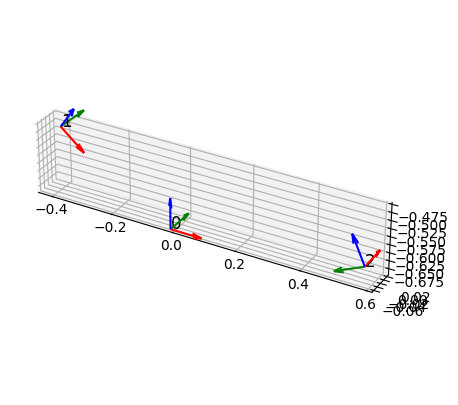

In [49]:
%matplotlib inline

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')

for cam_id, pose in pose_est.items():
    if "_" in cam_id:
        continue
    #pose_est[cam_id] = pose_est[cam_id].inv() @ pose_est[wrl_idx]
    plot_frame(ax, pose_est[cam_id]._pose , cam_id) # TODO: make a getter for the A matrix

# aspect ratio of the plot to be equal
ax.set_aspect('equal')

print(ax.get_box_aspect())
#make the plot interactive
plt.show()


In [43]:
%load_ext autoreload
%autoreload 2

from src.vican.vican.plot import plot_cams_3D

for cam_id, cam in dataset.cams.items():
    cam.extrinsics = pose_est[cam_id]
    # draw axis of frames of each camera

plot_cams_3D(dataset.cams.values())    

"file:///home/manuelf/ist/smart_retail/vicandocker/file.html"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Error: could not locate runnable browser

In [53]:
import open3d as o3d

# Load the PCD file
pc0 = o3d.io.read_point_cloud("dataset/pointcloud0.pcd")
pc1 = o3d.io.read_point_cloud("dataset/pointcloud1.pcd")
pc2 = o3d.io.read_point_cloud("dataset/pointcloud2.pcd")

# transform point clouds to world frame
pc0.transform(pose_est['0'].inv()._pose)
pc1.transform(pose_est['1'].inv()._pose)
pc2.transform(pose_est['2'].inv()._pose)

# Visualize the point cloud
o3d.visualization.draw_geometries([pc0, pc1])


libGL error: MESA-LOADER: failed to retrieve device information
libGL error: MESA-LOADER: failed to open amdgpu: /usr/lib/dri/amdgpu_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri)
libGL error: failed to load driver: amdgpu
libGL error: failed to open /dev/dri/card0: No such file or directory
libGL error: failed to load driver: radeonsi


In [46]:
for cam_id, pose in pose_est.items():
    if "_" in cam_id:
        continue
    print(cam_id)
    print(pose)
    

0
[[ 1.      0.     -0.     -0.0075]
 [-0.      1.      0.     -0.0649]
 [ 0.     -0.      1.     -0.6848]
 [ 0.      0.      0.      1.    ]]
1
[[ 0.7946  0.1474  0.589  -0.3788]
 [-0.0519  0.983  -0.1761 -0.0443]
 [-0.6049  0.1094  0.7887 -0.4677]
 [ 0.      0.      0.      1.    ]]
2
[[-0.0218 -0.9139 -0.4054  0.5453]
 [ 0.9998 -0.0215 -0.0054  0.0234]
 [-0.0038 -0.4054  0.9141 -0.6879]
 [ 0.      0.      0.      1.    ]]
